## Boundaries across which to calculate transport for Manuel 

pTM CAA paper 2021. Boundaries:
- Central sills
- Lancaster Sound (CAA3 area)
- Nares Strait
- Jones Sound

In [51]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
import cmocean
import netCDF4 as nc
import pandas as pd
from datetime import datetime

%matplotlib inline

In [48]:
file = nc.Dataset('/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridT_y2002m01d05.nc', 'r')
lons = np.array(file.variables['nav_lon'])
lats = np.array(file.variables['nav_lat'])
depth = np.array(file.variables['deptht'])

In [49]:
Pb_data   = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = Pb_data['Station names'].dropna().astype('str')
lons_obs  = Pb_data['station lon'].astype('float').dropna().values
lats_obs  = Pb_data['Station lat'].astype('float').dropna().values

#### Boundaries:

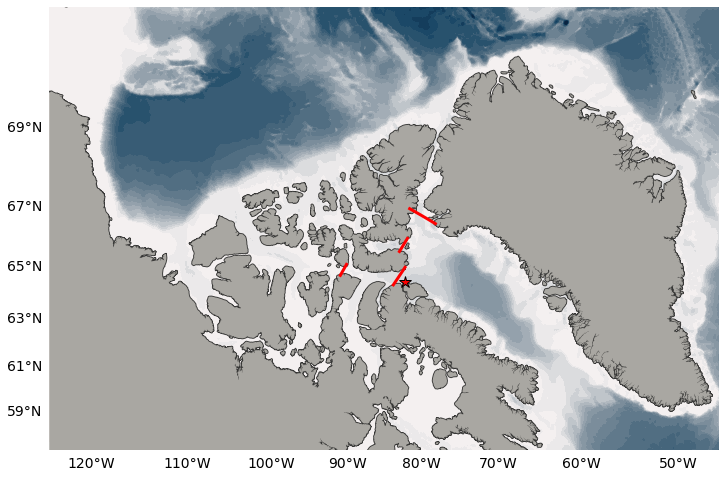

In [52]:
fig, ax1, proj1  = pickle.load( open('/ocean/brogalla/GEOTRACES/pickles/surface-land-map2.pickle','rb'))

x, y = proj1(lons, lats)
proj1.plot(x[1584,496:536], y[1584,496:536], '-r', zorder=5, linewidth=3) # Lancaster Sound
proj1.plot(x[1680,457:483], y[1680,457:483], '-r', zorder=5, linewidth=3) # Central Sills
proj1.plot(x[1580:1630,630], y[1580:1630,630], '-r', zorder=5, linewidth=3) # Nares Strait
proj1.plot(x[1607,554:583], y[1607,554:583], '-r', zorder=5, linewidth=3) # Jones Sound

x_CAA3, y_CAA3 = proj1(lons_obs[stn_names=='CAA3'], lats_obs[stn_names=='CAA3'])
proj1.plot(x_CAA3,y_CAA3,'*', c='r', zorder=5, markersize=12, markeredgecolor='k')

# Time series from pickles:

In [35]:
def load_transport(year, total_export):
    ts_CS, ts_JS, ts_NS, ts_LS = pickle.load( open('/ocean/brogalla/GEOTRACES/time-series/Manuel-2021-transport/time-series-'+\
                                                   str(year)+'.pickle','rb'))
    
    # Split into upper and lower water column
    split = 18 # depth level at which the split happens (48 m)
    
    # For each cross section, calculate the total export, so ignoring return flows, I want only the negative volume fluxes.
    # Then, sum the fluxes over the depth levels (axis=1) and cross-section gridpoints (axis=2).
    if total_export:
        upper_CS = np.ma.masked_where((ts_CS[:,0:split,:] > 0), ts_CS[:,0:split,:]).sum(axis=(1,2))
        lower_CS = np.ma.masked_where((ts_CS[:,split:,:] > 0), ts_CS[:,split:,:]).sum(axis=(1,2))
        upper_JS = np.ma.masked_where((ts_JS[:,0:split,:] > 0), ts_JS[:,0:split,:]).sum(axis=(1,2))
        lower_JS = np.ma.masked_where((ts_JS[:,split:,:] > 0), ts_JS[:,split:,:]).sum(axis=(1,2))
        upper_NS = np.ma.masked_where((ts_NS[:,0:split,:] > 0), ts_NS[:,0:split,:]).sum(axis=(1,2))
        lower_NS = np.ma.masked_where((ts_NS[:,split:,:] > 0), ts_NS[:,split:,:]).sum(axis=(1,2))
        upper_LS = np.ma.masked_where((ts_LS[:,0:split,:] > 0), ts_LS[:,0:split,:]).sum(axis=(1,2))
        lower_LS = np.ma.masked_where((ts_LS[:,split:,:] > 0), ts_LS[:,split:,:]).sum(axis=(1,2))
    # For the net export, I take the sum of all negative and positive volume fluxes
    else:
        upper_CS = ts_CS[:,0:split,:].sum(axis=(1,2))
        lower_CS = ts_CS[:,split:,:].sum(axis=(1,2))
        upper_JS = ts_JS[:,0:split,:].sum(axis=(1,2))
        lower_JS = ts_JS[:,split:,:].sum(axis=(1,2))
        upper_NS = ts_NS[:,0:split,:].sum(axis=(1,2))
        lower_NS = ts_NS[:,split:,:].sum(axis=(1,2))
        upper_LS = ts_LS[:,0:split,:].sum(axis=(1,2))
        lower_LS = ts_LS[:,split:,:].sum(axis=(1,2))
        
    return upper_CS,lower_CS,upper_JS,lower_JS,upper_NS,lower_NS,upper_LS,lower_LS

def create_time_series(year_start, year_end, total_export):

    
    uCS = np.empty([]); lCS = np.empty([]); uJS = np.empty([]); lJS = np.empty([])
    uNS = np.empty([]); lNS = np.empty([]); uLS = np.empty([]); lLS = np.empty([])
    
    # series of dates at which the model produces files.
    time_series=pd.date_range(start=str(year_start)+'-01-05', periods=72*(year_end+1-year_start), freq='5D')
    
    # load pickles where I stored the transport calculation for each year and calculate the sum of the transport across the boundary:
    for year in range(year_start, year_end+1):
        upperCS, lowerCS, upperJS, lowerJS, upperNS, lowerNS, upperLS, lowerLS = load_transport(year, total_export)
        uCS = np.append(uCS, upperCS); lCS = np.append(lCS, lowerCS)
        uJS = np.append(uJS, upperJS); lJS = np.append(lJS, lowerJS)
        uNS = np.append(uNS, upperNS); lNS = np.append(lNS, lowerNS)
        uLS = np.append(uLS, upperLS); lLS = np.append(lLS, lowerLS)
        
    return time_series, uCS[1:], lCS[1:], uJS[1:], lJS[1:], uNS[1:], lNS[1:], uLS[1:], lLS[1:]

def calc_transport(year_start, year_end, total_export=False):
    time_series, uCS, lCS, uJS, lJS, uNS, lNS, uLS, lLS = create_time_series(year_start, year_end, total_export)

    # Calculate the mean flux over the fill time period given by year_start to year_end
    upper_CS = uCS.mean(); lower_CS = lCS.mean();
    upper_JS = uJS.mean(); lower_JS = lJS.mean();
    upper_NS = uNS.mean(); lower_NS = lNS.mean();
    upper_LS = uLS.mean(); lower_LS = lLS.mean();
    
    # Print out the mean volume flux across the boundaries: (sverdrup is 1 million m3/s)
    if total_export:
        print('Total export across boundaries: units of Sverdrup')
    else:
        print('Net transport across boundaries: units of Sverdrup')
    print('--- Central Sills:   upper ocean = {:.3f}, lower ocean = {:.3f}, sum = {:.3f}'.format(upper_CS*1e-6, lower_CS*1e-6, (upper_CS+lower_CS)*1e-6))
    print('--- Jones Sound:     upper ocean = {:.3f}, lower ocean = {:.3f}, sum = {:.3f}'.format(upper_JS*1e-6, lower_JS*1e-6, (upper_JS+lower_JS)*1e-6))
    print('--- Nares Strait:    upper ocean = {:.3f}, lower ocean = {:.3f}, sum = {:.3f}'.format(upper_NS*1e-6, lower_NS*1e-6, (upper_NS+lower_NS)*1e-6))
    print('--- Lancaster Sound: upper ocean = {:.3f}, lower ocean = {:.3f}, sum = {:.3f}'.format(upper_LS*1e-6, lower_LS*1e-6, (upper_LS+lower_LS)*1e-6))
    return
    
def plot_transport(time_series, uCS, lCS, uJS, lJS, uNS, lNS, uLS, lLS):
    # Create 4 subplots showing the time series of volume flux across each of the boundaries
    
    fig, ax = plt.subplots(2,2, figsize=(15,8))

    ax[0,0].plot([time_series[0], time_series[-1]], [0,0], '-k')
    ax[0,0].plot(time_series, uCS*1e-6, label='Upper')
    ax[0,0].plot(time_series, lCS*1e-6, label='Lower')
    ax[0,0].set_ylabel('Transport (Sv)')
    ax[0,0].set_title('Central Sills')
    ax[0,0].legend(fontsize=13, frameon=False)
    
    ax[0,1].plot([time_series[0], time_series[-1]], [0,0], '-k')
    ax[0,1].plot(time_series, uLS*1e-6, label='upper')
    ax[0,1].plot(time_series, lLS*1e-6, label='lower')
    ax[0,1].set_title('Lancaster Sound')    

    ax[1,0].plot([time_series[0], time_series[-1]], [0,0], '-k')
    ax[1,0].plot(time_series, uJS*1e-6, label='upper')
    ax[1,0].plot(time_series, lJS*1e-6, label='lower')
    ax[1,0].set_title('Jones Sound')
    ax[0,0].set_ylabel('Transport (Sv)')
    
    ax[1,1].plot([time_series[0], time_series[-1]], [0,0], '-k')
    ax[1,1].plot(time_series, uNS*1e-6, label='upper')
    ax[1,1].plot(time_series, lNS*1e-6, label='lower')
    ax[1,1].set_title('Nares Strait')
    return

In [36]:
calc_transport(2002, 2019, total_export=True)

Total export across boundaries: units of Sverdrup
--- Central Sills:   upper ocean = -0.294, lower ocean = -0.447, sum = -0.741
--- Jones Sound:     upper ocean = -0.057, lower ocean = -0.161, sum = -0.218
--- Nares Strait:    upper ocean = -0.444, lower ocean = -1.565, sum = -2.009
--- Lancaster Sound: upper ocean = -0.487, lower ocean = -1.907, sum = -2.394


In [37]:
calc_transport(2002, 2019, total_export=False)

Net transport across boundaries: units of Sverdrup
--- Central Sills:   upper ocean = -0.280, lower ocean = -0.413, sum = -0.693
--- Jones Sound:     upper ocean = -0.003, lower ocean = -0.007, sum = -0.010
--- Nares Strait:    upper ocean = -0.219, lower ocean = -0.714, sum = -0.933
--- Lancaster Sound: upper ocean = -0.249, lower ocean = -0.447, sum = -0.696


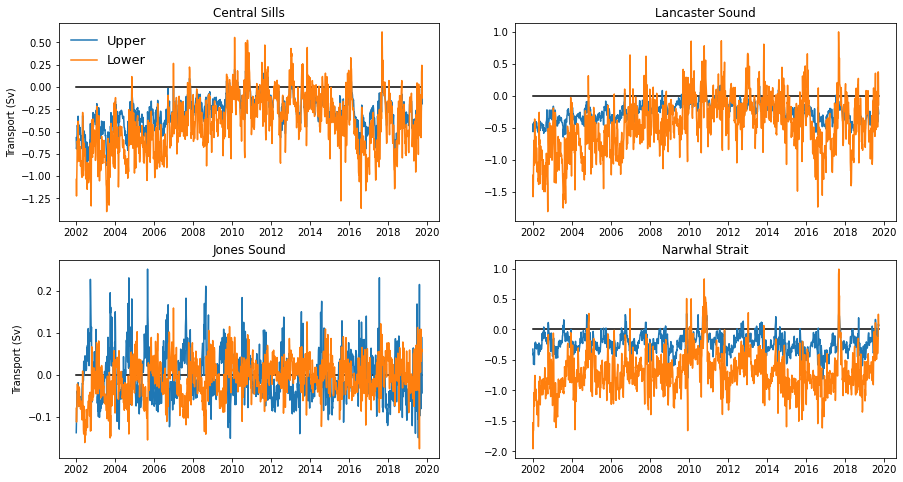

In [40]:
time_series, uCS, lCS, uJS, lJS, uNS, lNS, uLS, lLS = create_time_series(2002, 2019)

plot_transport(time_series, uCS, lCS, uJS, lJS, uNS, lNS, uLS, lLS)